### scmap to compare our gonadal immune cells to myeloid cells from Bian et al., 2020

In [1]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata
sc.settings.set_figure_params(dpi=80)

In [2]:
import rpy2.rinterface_lib.callbacks
import logging

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
import anndata2ri
anndata2ri.activate()

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(Matrix)
library(scmap)

#### Load data

In [48]:
path_to_bian = '/nfs/team292/vl6/Microglia/'
path_to_atlas = '/nfs/team292/vl6/immune_fetal_gonads/'

In [68]:
bian = sc.read(path_to_bian + 'Paper_microglia.h5ad')
bian = anndata.AnnData(X = bian.raw.X, var = bian.raw.var, obs = bian.obs)
bian.shape

(1231, 18917)

In [69]:
atlas = sc.read(path_to_atlas +'immune_merged_lineages.h5ad')
atlas.shape

(20556, 21209)

In [70]:
atlas = anndata.AnnData(X = atlas.raw.X, var = atlas.raw.var, obs = atlas.obs)
atlas.shape

(20556, 29052)

#### Intersect genes

In [71]:
bian_genes = bian.var_names.to_list()
atlas_genes = atlas.var_names.to_list()

from functools import reduce
inters = reduce(np.intersect1d, (bian_genes, atlas_genes))
len(inters)

16299

In [72]:
bian = bian[:, list(inters)]
bian

View of AnnData object with n_obs × n_vars = 1231 × 16299
    obs: 'tissue', 'paper_annotation', 'stage', 'individual', 'paper_cluster', 'n_genes', 'n_counts', 'sample'
    var: 'n_cells'

In [73]:
atlas = atlas[:, list(inters)]

#### Convert anndata to SingleCellExperiment

In [74]:
%%R -i atlas
atlas

class: SingleCellExperiment 
dim: 16299 20556 
metadata(0):
assays(1): X
rownames(16299): A1BG A1CF ... ZYX ZZEF1
rowData names(256): gene_ids.0.0 feature_types.0.0 ... variances.1
  variances_norm.1
colnames(20556): FCA_GND8047884_CCCATACAGAGATGAG
  FCA_GND8047884_CTTAGGATCAGTGCAT ...
  HCA_F_GON10941969_TTTCCTCTCCTTGACC HCA_F_GON10941969_TTTGGTTCAAGGTTCT
colData names(65): batch batch_collection ... prob_pro.B.cell lineages
reducedDimNames(0):
altExpNames(0):


In [75]:
%%R -i bian
bian

class: SingleCellExperiment 
dim: 16299 1231 
metadata(0):
assays(1): X
rownames(16299): A1BG A1CF ... ZYX ZZEF1
rowData names(1): n_cells
colnames(1231): YS5_TKR180900693_HT3YJCCXY_L4_sc60
  YS5_TKR180900693_HT3YJCCXY_L4_sc64 ... L3_FKDL190665156.1a_sc47
  L3_FKDL190665156.1a_sc48
colData names(8): tissue paper_annotation ... n_counts sample
reducedDimNames(0):
altExpNames(0):


#### Feature selection

In [76]:
%%R 

counts <- assay(bian, "X")
libsizes <- colSums(counts)
size.factors <- libsizes/mean(libsizes)
logcounts(bian) <- log2(t(t(counts)/size.factors) + 1)
assayNames(bian)

[1] "X"         "logcounts"



FALSE  TRUE 
15999   300 


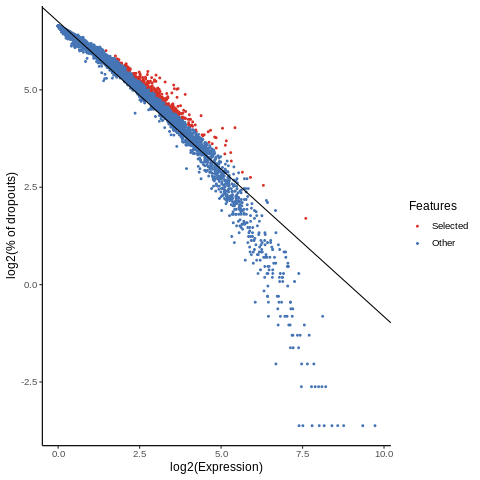

In [77]:
%%R

rowData(bian)$feature_symbol <- rownames(bian)
logcounts(bian) <- as.matrix(logcounts(bian))
bian <- selectFeatures(bian, n_features = 300, suppress_plot = FALSE)
print(table(rowData(bian)$scmap_features))

### scmap-cluster

           Mac_2       MkP     ErP      GMP Monocyte Myeloblast Lymphoblast
A2M    6.3961661 0.0000000 0.00000 0.000000 2.434667   0.000000    0.000000
AAK1   5.0784493 0.8896725 0.00000 1.377855 3.646283   4.023477    0.750214
ABCG2  5.4177824 0.0000000 0.00000 0.000000 1.286528   0.000000    0.000000
ACAA1  1.0587831 1.8234246 3.78445 1.603184 3.297013   2.729270    4.065105
ADAM28 0.7413152 0.0000000 0.00000 0.000000 4.257195   0.000000    4.885229
ADAP2  7.1489448 0.0000000 0.00000 0.000000 5.102202   1.930591    0.000000
             LMP      EMP Mast cell    Mac_4    Mac_1      ILC    Mac_3
A2M    1.3511106 0.000000  0.000000 7.541290 6.160626 0.000000 6.367759
AAK1   1.8842761 0.000000  1.212564 5.578590 4.689407 4.887467 5.371387
ABCG2  0.8231866 0.000000  0.000000 3.373880 5.583687 0.000000 5.059786
ACAA1  3.8297130 3.765198  1.434175 0.000000 2.488334 0.000000 3.430538
ADAM28 4.5268781 0.000000  0.000000 5.917298 0.000000 0.000000 0.000000
ADAP2  3.5046414 0.000000  0.000000 

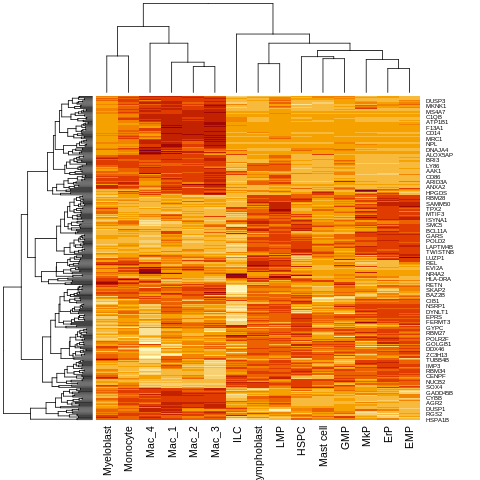

In [78]:
%%R 

bian <- indexCluster(bian, cluster_col = "paper_cluster")
print(head(metadata(bian)$scmap_cluster_index))
heatmap(as.matrix(metadata(bian)$scmap_cluster_index))

#### Projection

In [79]:
%%R 

rowData(atlas)$feature_symbol <- rownames(atlas)
counts <- assay(atlas, "X")
libsizes <- colSums(counts)
size.factors <- libsizes/mean(libsizes)
logcounts(atlas) <- log2(t(t(counts)/size.factors) + 1)
logcounts(atlas) <- as.matrix(logcounts(atlas))
assayNames(atlas)

[1] "X"         "logcounts"


In [80]:
%%R -o scmapCluster_results

scmapCluster_results <- scmapCluster(
  projection = atlas, 
  index_list = list(
    bian = metadata(bian)$scmap_cluster_index
  )
)

In [81]:
%%R 

print(head(scmapCluster_results$scmap_cluster_labs))
print(head(scmapCluster_results$scmap_cluster_siml))
print(head(scmapCluster_results$combined_labs))

     bian        
[1,] "unassigned"
[2,] "unassigned"
[3,] "Myeloblast"
[4,] "unassigned"
[5,] "Mac_1"     
[6,] "unassigned"
          bian
[1,] 0.4342971
[2,] 0.5580652
[3,] 0.7249438
[4,] 0.3322989
[5,] 0.7736249
[6,] 0.5554887
[1] "unassigned" "unassigned" "Myeloblast" "unassigned" "Mac_1"     
[6] "unassigned"


In [82]:
labels = list(scmapCluster_results[0])

In [83]:
atlas.obs['scmap_labels'] = labels
atlas.obs['scmap_labels'].value_counts(dropna = False)

Trying to set attribute `.obs` of view, copying.


unassigned     16083
Mac_1           1416
Mac_3            838
Mac_2            765
Mac_4            508
Monocyte         347
Myeloblast       337
ErP              134
GMP               28
Mast cell         26
HSPC              20
Lymphoblast       18
MkP               16
EMP               11
LMP                9
Name: scmap_labels, dtype: int64

In [84]:
similarities = scmapCluster_results[1]
similarities = [val for sublist in similarities for val in sublist]
#similarities

In [85]:
atlas.obs['scmap_similarities'] = similarities

#### Save scmap results 

In [86]:
atlas.obs[['scmap_labels', 'scmap_similarities']].to_csv(path_to_atlas + 'scmap_from_Bian.csv')